# Lesson 5 — Gaussian Discriminant Analysis & Naive Bayes  

## Important context
This lesson builds directly on **Lesson 3 and Lesson 4**.

- Logistic Regression / Softmax → **Discriminative models**
- GDA / Naive Bayes → **Generative models**
- Same goal (classification), different assumptions and strategy



## Outline
1. Discriminative vs Generative learning
2. Gaussian Discriminant Analysis (GDA)
3. GDA decision boundaries (linear vs quadratic)
4. Naive Bayes classifier
5. Conditional independence assumption
6. When these models win (and fail)


## Imports

In [192]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

## 1. Discriminative vs Generative Models

### Discriminative
- Model: $$P(y \mid x)$$
- Examples: Logistic Regression, Softmax, SVM
- Focus: decision boundary

### Generative
- Model: $$P(x \mid y) \; \text{and} \; P(y)$$
- Use Bayes rule to compute $$P(y \mid x)$$
- Examples: GDA, Naive Bayes

**Key idea:**  
Generative models try to model how the data was *generated*.


## 2. Gaussian Discriminant Analysis (GDA)

Assumptions:
- Class-conditional densities are Gaussian
- Each class has mean $$\mu_k$$
- Covariance $$\Sigma$$ (shared or per-class)

### Model
$$
P(x \mid y=k) = \mathcal{N}(\mu_k, \Sigma)
$$

Class prior:
$$
P(y=k) = \phi_k
$$

Prediction:
$$
\hat{y} = \arg\max_k \; P(x \mid y=k) P(y=k)
$$


## 3. GDA Implementation (Binary Classification)

In [193]:
def fit_gda(X, y):
    """Binary GDA with shared covariance"""
    m, d = X.shape

    y = y.reshape(-1)
    X0 = X[y == 0]
    X1 = X[y == 1]

    mu0 = X0.mean(axis=0)
    mu1 = X1.mean(axis=0)

    Sigma = (
        ((X0 - mu0).T @ (X0 - mu0)) +
        ((X1 - mu1).T @ (X1 - mu1))
    ) / m

    phi = np.mean(y)

    return mu0, mu1, Sigma, phi

In [194]:
def gda_predict(X, mu0, mu1, Sigma, phi):
    invS = np.linalg.inv(Sigma)

    def score(x, mu, prior):
        return (
            -0.5 * (x - mu).T @ invS @ (x - mu)
            + np.log(prior)
        )

    preds = []
    for x in X:
        s0 = score(x, mu0, 1 - phi)
        s1 = score(x, mu1, phi)
        preds.append(1 if s1 > s0 else 0)
    return np.array(preds)


### GDA on Synthetic Gaussian Data

In [195]:
# Generate Gaussian data
n = 300
mu0 = np.array([-1, 0])
mu1 = np.array([1, 0])
Sigma = np.array([[1, 0.3], [0.3, 1]])

X0 = np.random.multivariate_normal(mu0, Sigma, n//2)
X1 = np.random.multivariate_normal(mu1, Sigma, n//2)

X = np.vstack([X0, X1])
y = np.array([0]*(n//2) + [1]*(n//2))

# Standardize
X = (X - X.mean(axis=0)) / X.std(axis=0)

mu0_hat, mu1_hat, Sigma_hat, phi_hat = fit_gda(X, y)
preds = gda_predict(X, mu0_hat, mu1_hat, Sigma_hat, phi_hat)
correct = preds == y
incorrect = ~correct

print("GDA accuracy:", np.mean(preds == y))

# --- build grid for contours ---
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 250),
    np.linspace(y_min, y_max, 250)
)

grid = np.c_[xx.ravel(), yy.ravel()]

invS = np.linalg.inv(Sigma_hat)

def gaussian_unnormalized_density(grid, mu):
    diff = grid - mu
    quad = np.sum((diff @ invS) * diff, axis=1)   # (x-mu)^T invS (x-mu)
    return np.exp(-0.5 * quad)

Z0 = gaussian_unnormalized_density(grid, mu0_hat).reshape(xx.shape)
Z1 = gaussian_unnormalized_density(grid, mu1_hat).reshape(xx.shape)

GDA accuracy: 0.8833333333333333


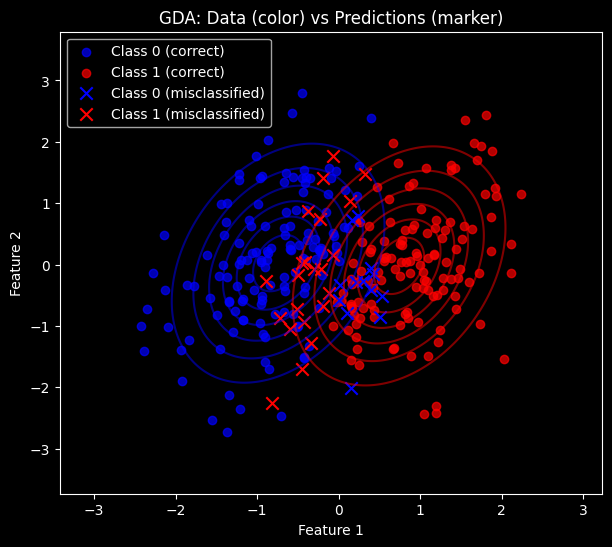

In [196]:
plt.figure(figsize=(7,6))

# Correct predictions
plt.scatter(X[correct & (y==0), 0], X[correct & (y==0), 1],
            color="blue", marker="o", alpha=0.7, label="Class 0 (correct)")
plt.scatter(X[correct & (y==1), 0], X[correct & (y==1), 1],
            color="red", marker="o", alpha=0.7, label="Class 1 (correct)")

# Incorrect predictions
plt.scatter(X[incorrect & (y==0), 0], X[incorrect & (y==0), 1],
            color="blue", marker="x", s=80, label="Class 0 (misclassified)")
plt.scatter(X[incorrect & (y==1), 0], X[incorrect & (y==1), 1],
            color="red", marker="x", s=80, label="Class 1 (misclassified)")

# Contours (unchanged)
plt.contour(xx, yy, Z0, levels=7, colors="blue", alpha=0.5)
plt.contour(xx, yy, Z1, levels=7, colors="red", alpha=0.5)

plt.title("GDA: Data (color) vs Predictions (marker)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


## 4. Naive Bayes Classifier

Naive Bayes assumes **conditional independence** of features:

$$
P(x \mid y) = \prod_{j=1}^d P(x_j \mid y)
$$

This is almost never true — yet Naive Bayes works surprisingly well.


## 5. Gaussian Naive Bayes (Continuous Features)

In [197]:
def fit_gaussian_nb(X, y):
    classes = np.unique(y)
    params = {}

    for c in classes:
        Xc = X[y == c]
        params[c] = {
            "mu": Xc.mean(axis=0),
            "var": Xc.var(axis=0) + 1e-9,
            "prior": len(Xc) / len(X)
        }
    return params

In [198]:
def gaussian_log_pdf(x, mu, var):
    return -0.5 * (
        np.log(2 * np.pi * var) +
        ((x - mu) ** 2) / var
    )

def predict_gaussian_nb(X, params):
    preds = []
    for x in X:
        scores = {}
        for c, p in params.items():
            log_likelihood = np.sum(gaussian_log_pdf(x, p["mu"], p["var"]))
            scores[c] = log_likelihood + np.log(p["prior"])
        preds.append(max(scores, key=scores.get))
    return np.array(preds)

nb_params = fit_gaussian_nb(X, y)
nb_preds = predict_gaussian_nb(X, nb_params)

print("Naive Bayes accuracy:", np.mean(nb_preds == y))

Naive Bayes accuracy: 0.86


### Naive Bayes on the Same Data

In [199]:
#Build grid
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]

# Compute log-posteriors on grid
logp0 = []
logp1 = []

for x in grid:
    # class 0
    p0 = nb_params[0]
    lp0 = (
        np.sum(gaussian_log_pdf(x, p0["mu"], p0["var"]))
        + np.log(p0["prior"])
    )
    logp0.append(lp0)

    # class 1
    p1 = nb_params[1]
    lp1 = (
        np.sum(gaussian_log_pdf(x, p1["mu"], p1["var"]))
        + np.log(p1["prior"])
    )
    logp1.append(lp1)

logp0 = np.array(logp0).reshape(xx.shape)
logp1 = np.array(logp1).reshape(xx.shape)

# Decision surface
Z = logp1 - logp0


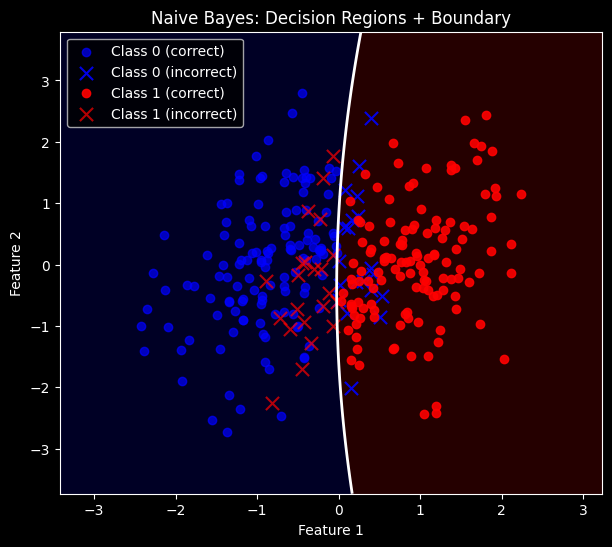

In [200]:
y1 = y.reshape(-1)
p1 = nb_preds.reshape(-1)

t0_p0 = (y1 == 0) & (p1 == 0)  # blue o
t0_p1 = (y1 == 0) & (p1 == 1)  # blue x
t1_p1 = (y1 == 1) & (p1 == 1)  # red x
t1_p0 = (y1 == 1) & (p1 == 0)  # red o

plt.figure(figsize=(7,6))

# Filled background (soft regions)
plt.contourf(xx, yy, Z > 0, levels=1, alpha=0.15, colors=["blue", "red"])

# Decision boundary
plt.contour(xx, yy, Z, levels=[0], colors="white", linewidths=2)

# Data points: color=true, marker=prediction
plt.scatter(X[t0_p0,0], X[t0_p0,1], color="blue", marker="o", alpha=0.7, label="Class 0 (correct)")
plt.scatter(X[t0_p1,0], X[t0_p1,1], color="blue", marker="x", s=90, alpha=0.9, label="Class 0 (incorrect)")

plt.scatter(X[t1_p1,0], X[t1_p1,1], color="red",  marker="o", alpha=0.9, label="Class 1 (correct)")
plt.scatter(X[t1_p0,0], X[t1_p0,1], color="red",  marker="x", s=90, alpha=0.7, label="Class 1 (incorrect)")

plt.title("Naive Bayes: Decision Regions + Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


## Key Takeaways (CS229 framing)

- GDA and Naive Bayes are **generative models**
- They model $$P(x \mid y)$$ explicitly
- GDA assumes Gaussian structure
- Naive Bayes assumes conditional independence
- These assumptions are strong — but often effective with limited data

**Strategic insight:**  
Generative models can outperform discriminative ones when data is scarce or assumptions are approximately correct.
